# Introduction and basic usage of the NCrystal Python API

This notebook describes the basic typical usage of NCrystal Python API, and lays the foundation for further more detailed tutorials.

## Preamble
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [1]:
#Optionally install dependencies via pip. The default is to do this only
#on Google Colab, but you can modify the next line to do it always:
always_do_pip_installs = False # Set to True to enable outside Google Colab
import os
if always_do_pip_installs or os.environ.get("COLAB_RELEASE_TAG"):
    %pip -q install ncrystal ipympl numpy matplotlib

In [2]:
#enable inline matplotlib plots:
if os.environ.get("COLAB_RELEASE_TAG"):
  print("Google Colab detected, matplotlib plots will not be interactive")
  %matplotlib inline
  import matplotlib
  matplotlib.rcParams.update({"figure.autolayout": True})
else:
  print("Enabling interactive matplotlib plots (requires ipympl installed)")
  %matplotlib ipympl
  import matplotlib
  matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),
                              "figure.dpi":150,
                              'font.size':5,
                              "figure.autolayout": True})

Enabling interactive matplotlib plots (requires ipympl installed)


In [3]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [4]:
import NCrystal as NC
assert NC.version_num >=  3009004
NC.test() #< quick unit test that installation works!

Tests completed succesfully


## Using basic NCrystal objects
Jumping right into it, let us load a material defined by a *cfg-string* and plot the cross sections. Most often, a cfg-string is a data file name, and perhaps some parameters - like for setting the temperature:

In [5]:
mat = NC.load('Al_sg225.ncmat;temp=10C')

In reality, the `NC.load` call in the previous line has actually combined into `mat` three kinds of NCrystal objects, that together provides all the information and capabilities that NCrystal provides for that material: An `Info` object, a `Scatter` object and an `Absorption` object. The `Info` object provides general information about the material like density and composition, as well as details about the static structure and dynamics of the material. The `Scatter` and `Absorption` objects provides algorithms concerning neutron interactions in the material. The `mat` object itself contains a few convenience utilities. For instance, we can inspect neutron cross section values:

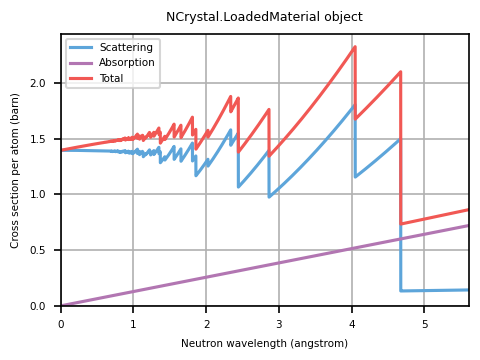

In [6]:
mat.plot()

The entire Python API of NCrystal is enriched with doc-strings for inline help, let us learn more about this `mat` material object:

In [7]:
help(mat)

Help on LoadedMaterial in module NCrystal.core object:

class LoadedMaterial(builtins.object)
 |  LoadedMaterial(cfgstr)
 |
 |  This convenience class combines loaded Info, Scatter, and Absorption
 |  objects of the same material.
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      Instantiate from a cfg-string which will be passed to the createInfo,
 |      createScatter, and createAbsorption functions.
 |
 |      As a special case, one can also pass a TextData object to this function,
 |      and it will be loaded as by calling the directLoad(..)
 |      function. Likewise, python strings beginning with 'NCMAT' and containing
 |      at least one newline, will also be assumed to be raw NCMAT data and
 |      loaded accordingly. For more control, however, the .directLoad function
 |      is recommended.
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  dump(self, verbose=0)
 |      Convenience method for print informa

Indeed, we can see that there are essentially `.info`, `.absorption`, and `.scatter` objects as properties as well as convenience methods `.plot()`, `.dump()`, `.xsect(..)` and `.macroscopic_xsect(..)`. The two latter sums up cross sections of the `.absorption` and `.scatter` objects. We check that we can access the more fundamental objects:

In [8]:
print( mat.info )
print( mat.scatter )
print( mat.absorption )

And here we request a brief printout of the three objects:

In [9]:
mat.dump()


>>> Material info:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
-----------------------------

The `NC.load(..)` method is merely a convenience method for interactive work. If you only need a particular object you can instead call `createInfo`. `createScatter` or `createAbsorption` directly:

In [10]:
info_Al = NC.createInfo('Al_sg225.ncmat')
info_Al.dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

If you are interested in getting a bit more info, you can increase the verbosity (up to 2). This will affect the HKL listing and (for very complex materials) the list of atom positions:

In [11]:
info_Al.dump(verbose=1)

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

For more rich plotting of cross sections, the `plot_xsects` and `plot_xsect` functions from the `NCrystal.plot` module can be used. For instance, dive into the different scattering cross section components:

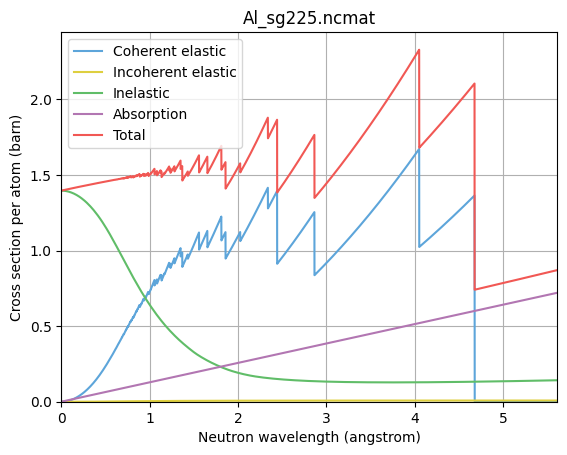

In [2]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('Al_sg225.ncmat')#supply the argument show_absorption=False to hide absorption

Or perhaps you prefer macroscopic cross sections (a.k.a. inverse penetration depth). It is of course just scaled with the number density (atoms/volume) so only the Y-axis scale and text changes:

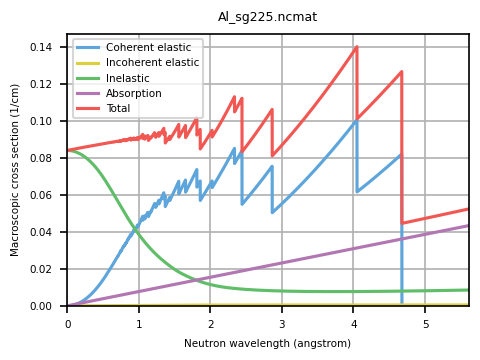

In [13]:
ncplot.plot_xsect('Al_sg225.ncmat',xsmode='macroscopic')

If you wish to overlay different materials and compare cross sections, you have to use the `plot_xsects` (plural `s` at the end) function instead:

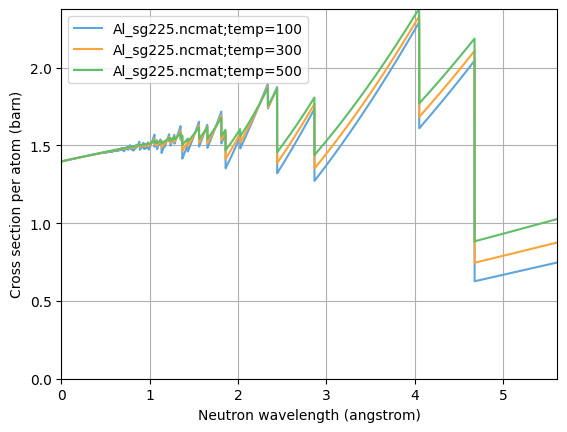

In [8]:
ncplot.plot_xsects('Al_sg225.ncmat;temp=100K',
                   'Al_sg225.ncmat;temp=300K',
                   'Al_sg225.ncmat;temp=500K')

## Simple usage of Scatter or Absorption objects

If you need to extract cross section values, you can do so with the `Scatter` and `Absorption` objects. Note that NCrystal use electronvolt (eV) and angstrom (Å) as default units for energy and lengths respectively:

In [15]:
scatter_Al = NC.createScatter('Al_sg225.ncmat')#NB: default temperature for most materials is 293.15K
print( '%g barn'%scatter_Al.xsect(wl=1.8) )#query at a single neutron wavelength
print( '%g eV'%NC.wl2ekin(1.8) )#NB: ekin2wl exists as well, plus many more conversion fcts in NCrystal.constants module
print( '%g barn'%scatter_Al.xsect(ekin=0.025248212841151512) )#query at a single neutron energy

1.44857 barn
0.0252482 eV
1.44857 barn


We can use numpy arrays as well:

In [16]:
import numpy
wavelengths = numpy.linspace(0.0,10.0,20)
print( wavelengths )
print( scatter_Al.xsect(wl=wavelengths) )

[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]
[1.39666864 1.39188337 1.40453992 1.33523631 1.33241165 1.20903676
 1.15591526 1.52057309 1.24379033 0.14075217 0.14597288 0.1522182
 0.15916807 0.16664082 0.17451158 0.18269072 0.19114923 0.19978598
 0.20860266 0.21752032]


To extract single components, we must create a scatter instance with just that component, using the cfg-string parameter `comp` (+changing the temperature to show the usage of multiple parameters):

1.70491 barn


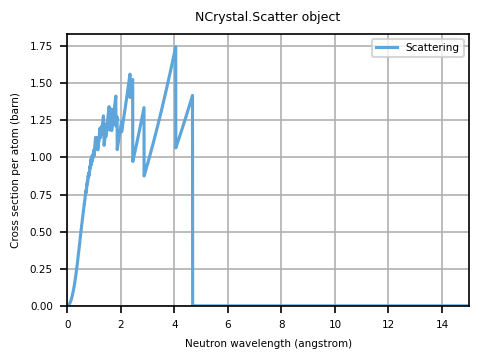

In [17]:
scatter_Al_only_bragg = NC.createScatter('Al_sg225.ncmat;comp=bragg;temp=100K')
print( '%g barn'%scatter_Al_only_bragg.xsect(wl=4.0) )
scatter_Al_only_bragg.plot()

In addition to extracting cross sections with both `Scatter` and `Absorption` objects, one can of course also use a `Scatter` object to perform random sampling of scattering events by using the `.scatter` method. As usual, we can use the builtin `help` function to figure out how:

In [18]:
help(scatter_Al)
help(scatter_Al.scatter)
help(scatter_Al.sampleScatterIsotropic)

Help on Scatter in module NCrystal.core object:

class Scatter(Process)
 |  Scatter(cfgstr)
 |
 |  Base class for calculations of scattering in materials.
 |
 |  Note that kinetic energies are in electronvolt and direction vectors are
 |  tuples of 3 numbers.
 |
 |  Method resolution order:
 |      Scatter
 |      Process
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      create Scatter object based on cfg-string (same as using createScatter(cfgstr))
 |
 |  clone(self, rng_stream_index=None, for_current_thread=False)
 |      Clone object. The clone will be using the same physics models and sharing any
 |      read-only data with the original, but will be using its own private copy
 |      of any mutable caches and will get an independent RNG stream. All in
 |      all, this means that the objects are safe to use concurrently in
 |      multi-threaded programming, as long as each thread gets its own
 |      clone. Return value is th

And we can do a little plot of scattering events for a 1.8Å neutron:

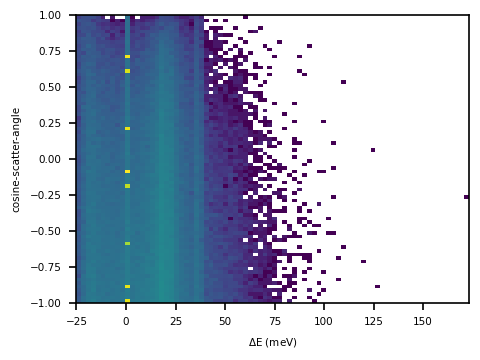

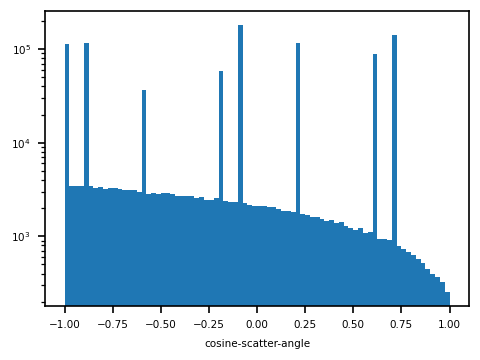

In [19]:
ekin_i = NC.wl2ekin(1.8)
ekin_f, mu = scatter_Al.scatter(ekin=ekin_i,repeat=int(1e6))
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
plt.hist2d((ekin_f-ekin_i)*1000,mu,
           bins=80,
           norm=matplotlib.colors.LogNorm())
plt.ylim(-1,1)
plt.ylabel('cosine-scatter-angle')
plt.xlabel(r'$\Delta$E (meV)')
plt.show()
plt.figure()
plt.hist(mu,bins=80)
plt.semilogy()
plt.xlabel('cosine-scatter-angle')
plt.show()

## Simple usage of Info objects
The `Info` object contain a range of supplementary information about the loaded material. Most notably it includes information about the material density and composition, but other information such as for instance Bragg diffraction structure factors ("HKL lists") or phonon DOS curves, can be access as well. See `help(NC.Info)` for complete details, here we will show a few examples:

In [20]:
info = NC.createInfo('Al2O3_sg167_Corundum.ncmat')

In [21]:
info.dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al2O3_sg167_Corundum.ncmat
----------------------------------------------------------------------------------------------------
Density : 3.99122 g/cm3, 0.117867 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 60% O 40% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 47.0748% O 52.9252% Al
----------------------------------------------------------------------------------------------------
Atom data:
   O  = O(cohSL=5.803fm cohXS=4.2317barn incXS=0.0008barn absXS=0.00019barn mass=15.9993u Z=8)
   Al = Al(cohSL=3.4

In [22]:
help(info)

Help on Info in module NCrystal.core object:

class Info(RCBase)
 |  Info(cfgstr)
 |
 |  Class representing information about a given material.
 |
 |  Objects might represent either multi- or single phase
 |  materials. Multi-phase objects contain a list of phases (which might
 |  themselves be either single or multi-phase objects). Most other fields
 |  (structure, hkl lists, dynamics, etc.) are single-phase specific and will
 |  be unavailable on multiphase-phase objects. Exceptions are phase-structure
 |  information (todo) which is only available on multi-phase objects, and
 |  fields which are available for both multi- and single-phase objects such as
 |  density, composition, temperature, and state of matter (where such are well
 |  defined).
 |
 |  Method resolution order:
 |      Info
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      create Info object based on cfg-string (same as using createInfo(cfgstr))
 |
 |  dspacingF

In [23]:
info.composition

[(0.6,
  O=O(cohSL=5.803fm cohXS=4.2317barn incXS=0.0008barn absXS=0.00019barn mass=15.9993amu Z=8)),
 (0.4,
  Al=Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815amu Z=13))]

In [24]:
for di in info.dyninfos:
    print(di)

DynamicInfo(O, fraction=60%, type=VDOS, npts=281)
DynamicInfo(Al, fraction=40%, type=VDOS, npts=352)


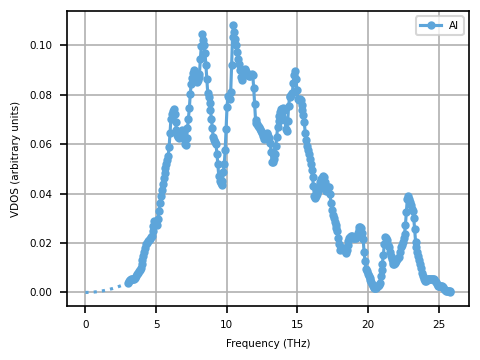

In [25]:
info.findDynInfo('Al').plot_vdos(unit='THz')#default unit is eV

In [26]:
for ai in info.atominfos:
    print(ai)

AtomInfo(O, 18, DebyeT=994.075K, MSD=0.00347696Aa^2, hasPositions=yes)
AtomInfo(Al, 12, DebyeT=742.637K, MSD=0.00334835Aa^2, hasPositions=yes)


In [27]:
import pprint
pprint.pprint(info.findAtomInfo('Al').positions)

((0.0, 0.0, 0.14782),
 (0.0, 0.0, 0.35218),
 (0.0, 0.0, 0.64782),
 (0.0, 0.0, 0.85218),
 (0.3333333333333333, 0.6666666666666666, 0.018846666666666668),
 (0.3333333333333333, 0.6666666666666666, 0.3144866666666667),
 (0.3333333333333333, 0.6666666666666666, 0.5188466666666667),
 (0.3333333333333333, 0.6666666666666666, 0.8144866666666667),
 (0.6666666666666666, 0.3333333333333333, 0.18551333333333334),
 (0.6666666666666666, 0.3333333333333333, 0.4811533333333333),
 (0.6666666666666666, 0.3333333333333333, 0.6855133333333333),
 (0.6666666666666666, 0.3333333333333333, 0.9811533333333333))


In [28]:
print(info.braggthreshold,'Aa')
print(info.density,'g/cm3')
print(info.numberdensity,'atoms/Aa^3')
print(info.sld,'10^-6/Aa^2')

6.9574242817577385 Aa
3.9912157584832233 g/cm3
0.11786695710760754 atoms/Aa^3
5.729984252829233 10^-6/Aa^2


For the list of HKL reflection planes, one can access them via the `.hklList()` or `.hklObjects()` methods. Note that both of them yield the planes with the longer d-spacings first, so you can always break out of the loop if you wish to forego the planes with shorter d-spacing:

In [29]:
for hkl in info.hklObjects():
    if hkl.d < 2.2:
        break
    print('-----------------------')
    #print the label, dyspacing, structure factor and multiplicity:
    print(hkl)
    #Access values as needed:
    print(f'   d = {hkl.d:g} Aa')
    print(f'   F^2 = {hkl.f2:g} barn')
    print(f'   multiplicity = {hkl.mult}')
    for h,l,k in zip(hkl.h,hkl.k,hkl.l):
        print(f'   hkl = {h}, {k}, {l}')

-----------------------
HKL( hkl_label=(1,0,-2), d=3.47871Aa, F2=4.97203barn, N=6 )
   d = 3.47871 Aa
   F^2 = 4.97203 barn
   multiplicity = 6
   hkl = 1, -2, 0
   hkl = 1, 2, -1
   hkl = 0, 2, 1
-----------------------
HKL( hkl_label=(1,0,4), d=2.5501Aa, F2=5.6695barn, N=6 )
   d = 2.5501 Aa
   F^2 = 5.6695 barn
   multiplicity = 6
   hkl = 1, 4, 0
   hkl = 1, -4, -1
   hkl = 0, -4, 1
-----------------------
HKL( hkl_label=(2,-1,0), d=2.3785Aa, F2=0.82099barn, N=6 )
   d = 2.3785 Aa
   F^2 = 0.82099 barn
   multiplicity = 6
   hkl = 2, 0, -1
   hkl = 1, 0, 1
   hkl = 1, 0, -2


As usual we can use the builtin documentation for these objects (using the `next(..)` function to get help for an hkl entry and not for the generator):

In [30]:
help(next(info.hklObjects()))

Help on HKLEntry in module NCrystal._hklobjects object:

class HKLEntry(builtins.object)
 |  HKLEntry(hh, kk, ll, mult, dsp, fsq, hklinfotype, issymeqv)
 |
 |  A group or family of HKL planes, all sharing the same value of d-spacing
 |  and structure factor (fsquared). If .is_symequiv evaluates to True, these
 |  exactly represent a group of symmetry-equivalent planes.
 |
 |  Methods defined here:
 |
 |  __init__(self, hh, kk, ll, mult, dsp, fsq, hklinfotype, issymeqv)
 |      For internal usage only, do not create therse objects manually.
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |
 |  d
 |      The d-spacing value in units of angstrom.
 |
 |  dspacing
 |      The d-spacing value in units of angstrom.
 |
 |  f2
 |      The squared structure factor (F^2) in units of barn.
 |
 |  fsquared
 |      The squared structure factor (F^2) in units of barn.
 |
 |  h
 |      A

## More about cfg-strings
As you have seen, a single NCrystal *cfg-string* like `"somefile.ncmat;par1=val1;par2=val2"` is all that is required to define a material in NCrystal. This is perhaps not very object-oriented or pythonic, but has the advantage that the same string can be used to define a material in a multitude of contexts:

* In Python
* On the command-line
* On a webpage, in an email to a colleage, etc.
* In OpenMC
* In McStas
* In McStasScript
* In Geant4
* ...

Best of all (especially for the NCrystal developers), we can add a new cfg-string parameter without having to update all NCrystal-bindings for OpenMC/McStas/Geant4/... every time. As soon as we add the parameter in NCrystal, all users who have access to the latest NCrystal release, will automatically be able to use the new parameter.

All the parameters are described in the wiki at https://github.com/mctools/ncrystal/wiki/CfgRefDoc but the most important ones are summarised here:

### Most important cfg-parameters

* **Temperature**:
  - Examples: `temp=100`, `temp=100K`, `temp=-10C`, `temp=100F`
  - All materials have a temperature, and it is not always 293.15! The `temp` parameter does exactly what you think it does. By default it assumes the value is in kelvin, but a unit can be added (must be one of `K`, `C`, or `F`.
* **Density**
  - Examples: `density=2.0gcm3`, `density=3.4kgm3`, `density=0.9x`.
  - Also does what you think it does. The last example scales the density by a factor of 0.9.
* **Scattering component toggling**
  - Current recognised component names are `coh_elas` (alias `bragg`), `incoh_elas`, `sans`, and `inelas`. `elas` refers to all components except `inelas`.
  - Syntax: `<compname>=0' (disable component), `comp=<compname1>,..,<compnamen>` (disable all but the listed components.
  - Examples: `...;comp=inelas,sans` (only inelastic and SANS),`...;inelas=0` (without inelastic),`...;inelas=0;comp=inelas` (oups, removed all components)
* **Modify atomic compositions**
  - Examples: `atomdb=H is D`, `atomdb=Al:is:0.9:Al:0.1:Cr`, `atomdb=Si29:28.97649466525u:4.7fm:0.001b:0.101b`, ...
* **Single crystal parameters**:
  - Single crystal models and orientations are primarily controlled by the parameters `mos`, `dir1`, `dir2`, and `dirtol`. Refer to the documentation linked aboved, and see the example in the next notebook.


For reference, it should be noted that you can also access information about the cfg-string parameters via built-in documentation:
```python
print(NC.generateCfgStrDoc()
```
Or from the command-line (supply `--doc --doc` twice to get full information):
```bash
$> nctool --doc --doc
```

## The nctool (a.k.a. ncrystal_inspectfile) commandline utility
If you are in working in a terminal, the `nctool` or `ncrystal_inspectfile` command (they are the exact same thing, but `nctool` is the future-proof name) provides a convenient interface to a lot of the most common tasks an NCrystal user might need, when composing a cfg-string for their simulation:

* Load the material and do cross section (or scattering) plots or information dumps to the terminal.
  * Investigate the effect of different cfg-parameters.
* Browse available files.
* Extract content of files (including virtual files)
* Quickly unit test an installation

The `nctool` command, **like all NCrystal cmdline tools** contain embedded documentation, accessible by the `--help` flag:

In [33]:
!nctool --help

usage: nctool [-h] [--version] [-d] [--mc SRCCFG GEOMCFG] [--common CFG]
              [--coh_elas] [--incoh_elas] [--sans] [--elastic] [--inelastic]
              [-a] [--phases] [-x [XRANGE]] [--logy] [--liny] [-e] [-p]
              [--test] [--doc] [--dpi DPI] [--cfg] [--plugins] [-b]
              [--extract DATANAME]
              [CFGSTR ...]

The most common usage of this tool is to load input data (usually .ncmat files)
with NCrystal (v3.9.4) and plot resulting isotropic cross sections for thermal
neutrons. This is done by specifying one or more configurations ("cfg-strings"),
which indicates data names (e.g. file names) and optionally cfg parameters
(e.g. temperatures). Specifying more than one configuration, results in a single
comparison plot of the total scattering cross section based on the different
materials. Specifying just a single file, results in a more detailed cross
section plot as well as a 2D plot of generated scatter angles. Other behaviours
can be obtained by 

In [34]:
!nctool --dump "Al_sg225.ncmat;temp=200K"

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

In [35]:
#Uncomment if you are OK with launching new windows with plots (and it might not work depending on how you run the notebook, but you can always try to run the command in a terminal window)
#!nctool "Al_sg225.ncmat;temp=200K"

In [36]:
#Uncomment if you are OK with launching new windows with plots (and it might not work depending on how you run the notebook, but you can always try to run the command in a terminal window)
#!nctool "Be_sg194.ncmat;temp=80K" "Be_sg194.ncmat;temp=150K" "Be_sg194.ncmat;temp=300K" --energy

In [37]:
!nctool --browse

==> 132 files from "stdlib" (stdlib, priority=120):
    AcrylicGlass_C5O2H8.ncmat
    AgBr_sg225_SilverBromide.ncmat
    Ag_sg225.ncmat
    Al2O3_sg167_Corundum.ncmat
    Al4C3_sg166_AluminiumCarbide.ncmat
    AlN_sg186_AluminumNitride.ncmat
    Al_sg225.ncmat
    Ar_Gas_STP.ncmat
    Au_sg225.ncmat
    BaF2_sg225_BariumFluoride.ncmat
    BaO_sg225_BariumOxide.ncmat
    Ba_sg229.ncmat
    Be3N2_sg206_BerylliumNitride.ncmat
    BeF2_sg152_Beryllium_Fluoride.ncmat
    BeO_sg186.ncmat
    Be_sg194.ncmat
    Bi_sg166.ncmat
    C_sg194_pyrolytic_graphite.ncmat
    C_sg227_Diamond.ncmat
    CaCO3_sg62_Aragonite.ncmat
    CaF2_sg225_CalciumFlouride.ncmat
    CaH2_sg62_CalciumHydride.ncmat
    CaO2H2_sg164_CalciumHydroxide.ncmat
    CaO_sg225_CalciumOxide.ncmat
    CaSiO3_sg2_Wollastonite.ncmat
    Ca_sg225.ncmat
    Ca_sg229_Calcium-gamma.ncmat
    CeO2_sg225_CeriumOxide.ncmat
    Cr_sg229.ncmat
    Cu2O_sg224_Cuprite.ncmat
    Cu_sg225.ncmat
    Dy2O3_sg206_DysprosiumOxide.ncmat
    Epoxy_Ar

In [38]:
!nctool --extract Al_sg225.ncmat

NCMAT v5
#
# Aluminium (Al, fcc, cubic, SG-225 / Fm-3m)
#
# Under usual conditions this phase exists from 0 to 933K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "Second edition. Interscience Publishers,
#     New York, Cubic closest packed, ccp, structure"
#    Wyckoff R W G (1963)
#    Crystallography Open Database entry 9008460
#    https://www.crystallography.net/cod/9008460.html
#
# This crystal structure is also compatible with structure obtained from:
#
#   https://www.crystallography.net/cod/9012428.html
#   https://www.crystallography.net/cod/9011602.html
#   https://www.crystallography.net/cod/9012002.html
#
# The VDOS curve was extracted by T. Kittelmann using the engauge digitizer
# software from Figure 1 of:
#
#    "First principles phonon calculations in materials science"
#    A. Togo and I. Tanaka, Scripta Materialia 108 (2015) 1-5
#    https://doi.org/10.1016/j.scriptamat.2015.07.021
#
@CELL
  cubic 4.04958
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al   0

## Sources of pre-defined materials
The first and foremost source, is of course materials pre-created by other scientists (be it NCrystal developers or your colleagues). Any complete NCrystal installation should include the standard data library ("stdlib") of NCMAT files. For the ~latest NCrystal release, it can be browsed online at the wiki: https://github.com/mctools/ncrystal/wiki/Data-library

So assuming you find the material (say, zirconia) you were looking for on that page, you can as usual proceed to have a look at it:

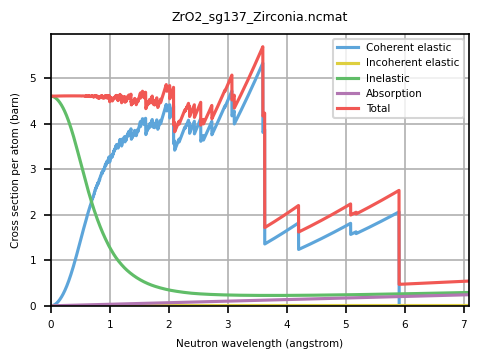

In [39]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('ZrO2_sg137_Zirconia.ncmat')#remember: room temperature by default

### Interlude: physical and virtual file data
Depending on your installation of NCrystal, the "files" in the standard data library might reside as physical files on-disk, or they might be "baked in" to the NCrystal binary library as virtual files. It should not matter to you. If you wish to get the raw content of a file, you can do so with the `createTextData` function:

In [40]:
td = NC.createTextData('ZrO2_sg137_Zirconia.ncmat')
# or this way, to prevent accidentally picking up a file you downloaded,
# edited, and left lying around in your working directory:
# td = NC.createTextData('stdlib::ZrO2_sg137_Zirconia.ncmat')

In [41]:
help(td)

Help on TextData in module NCrystal.core object:

class TextData(builtins.object)
 |  TextData(name)
 |
 |  Text data accessible line by line, with associated meta-data. This always
 |  include a UID (useful for comparison and downstream caching purposes) and
 |  the data type (e.g. "ncmat"). Optionally available is the last known
 |  on-disk path to a file with the same content, which might be useful in
 |  case the data needs to be passed to 3rd party software which can only
 |  work with physical files.
 |
 |  Text data objects are easily line-iterable, easily providing lines
 |  (without newline characters): for( auto& line : mytextdata ) {...}.  Of
 |  course, the raw underlying data buffer can also be accessed if needed.
 |
 |  The raw data must be ASCII or UTF-8 text, with line endings \n=CR=0x0A
 |  (Unix) or \r\n=LF+CR=0x0D0A (Windows/DOS). Other encodings might work
 |  only if 0x00, 0x0A, 0x0D bytes do not occur in them outside of line
 |  endings.
 |
 |  Notice that ancient

In [42]:
print(td.dataSourceName)
print(td.lastKnownOnDiskLocation)#will be None if file was virtual
print(td.dataType)
print('-- contents: --')
print(td.rawData)

ZrO2_sg137_Zirconia.ncmat
None
ncmat
-- contents: --
NCMAT v5
#
# Zirconium dioxide (ZrO2, Zirconia, tetragonal, SG-137 / P4_2/nmc))
#
# Under usual conditions this phase exists from 1443K to 2643K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "Simultaneous Structure and Size-Strain Refinement by the Rietveld Method"
#    Lutterotti, L. and Scardi, P. (1990)
#    DOI: https://dx.doi.org/10.1107/S0021889890002382
#    Crystallography Open Database entry 2300612
#    https://www.crystallography.net/cod/2300612.html
#
# This crystal structure is also compatible with structure obtained from:
#
#   https://www.crystallography.net/cod/1526427.html
#   https://www.crystallography.net/cod/1539831.html
#   https://materialsproject.org/materials/mp-2574
#
# The VDOS curves were calculated using Phonopy[1] input files from[2] and
# OCLIMAX[3] software by Kemal Ramic from ESS Spallation Physics group.
#
# References:
#  [1]: "First principles phonon calculations in materials s

Similarly, when you yourself need to add a new NCMAT file, you do not actually have to write a physical file into your filesystem (unless you need the file to persist after your current process is done of course). You can instead simply register the associated data as a physical file in the currently running process:

In [43]:
a_string_with_ncmat_data="""NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas
"""
NC.registerInMemoryFileData('silly_carbon.ncmat',a_string_with_ncmat_data)

In [44]:
print(NC.createTextData('silly_carbon.ncmat').rawData)

NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas



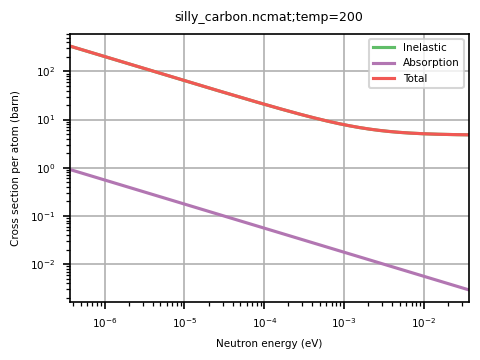

In [45]:
ncplot.plot_xsect('silly_carbon.ncmat;temp=200K',mode='ekin')

Of course, if all you wanted was to quickly plot the cross sections, you didn't need to register the file and invent a name for it. You could either do:

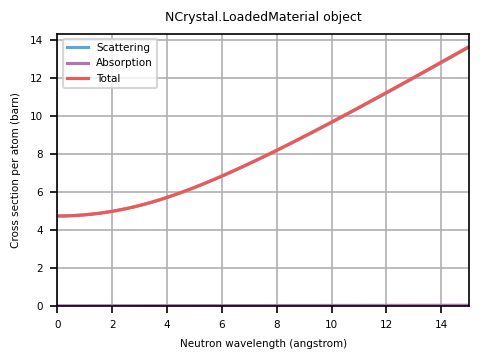

In [46]:
mat_silly=NC.load(a_string_with_ncmat_data)
mat_silly.plot()

Or, if you really didn't need to use the material for anything else than this plot:

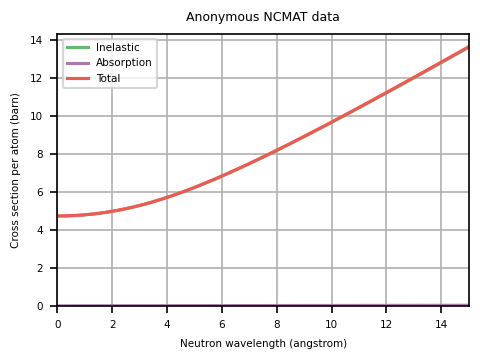

In [47]:
ncplot.plot_xsect(a_string_with_ncmat_data)

### NCrystal data source infrastructure
As we are starting to see, the NCrystal infrastructure which serves up data files based on "filenames" in cfg-strings is rather flexible. The `NCrystal.datasrc` module contain many functions which can be used to fine-tune this. For instance, if you keep your own edition to a data-library in some local folder, you can add that folder to the NCrystal search path. You can either do this by setting the `NCRYSTAL_DATA_PATH` variable (*before* loading NCrystal!), which can contain multiple directories separated by semi-colons in the usual unix fashion. Or you can add a directory to this search path dynamically:

In [48]:
import pathlib
extra_data_dir = pathlib.Path('./myextradatafiles/')
extra_data_dir.mkdir(exist_ok=True)
( extra_data_dir / 'my_extra_material.ncmat' ).write_text(a_string_with_ncmat_data)

129

In [49]:
!ls ./myextradatafiles

my_extra_material.ncmat


In [50]:
import NCrystal.datasrc as ncdatasrc
ncdatasrc.addCustomSearchDirectory(extra_data_dir)
td = NC.createTextData('my_extra_material.ncmat')
print(td.dataSourceName)
print(td.lastKnownOnDiskLocation)#will be None if file is virtual (but it won't be in this case)
print(td.dataType)
print('-- contents: --')
print(td.rawData)

my_extra_material.ncmat
/some/where/ncrystal-notebooks/notebooks/myextradatafiles/my_extra_material.ncmat
ncmat
-- contents: --
NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas



We have already seen how you can browse available data files via the command line, but you can of course also do so from Python:

In [51]:
NC.browseFiles(dump=True)

==> 1 file from "relpath" (/some/where/ncrystal-notebooks/notebooks, priority=140):
    myextradatafiles/my_extra_material.ncmat
==> 1 file from "virtual" (virtual, priority=130):
    silly_carbon.ncmat
==> 132 files from "stdlib" (stdlib, priority=120):
    AcrylicGlass_C5O2H8.ncmat
    AgBr_sg225_SilverBromide.ncmat
    Ag_sg225.ncmat
    Al2O3_sg167_Corundum.ncmat
    Al4C3_sg166_AluminiumCarbide.ncmat
    AlN_sg186_AluminumNitride.ncmat
    Al_sg225.ncmat
    Ar_Gas_STP.ncmat
    Au_sg225.ncmat
    BaF2_sg225_BariumFluoride.ncmat
    BaO_sg225_BariumOxide.ncmat
    Ba_sg229.ncmat
    Be3N2_sg206_BerylliumNitride.ncmat
    BeF2_sg152_Beryllium_Fluoride.ncmat
    BeO_sg186.ncmat
    Be_sg194.ncmat
    Bi_sg166.ncmat
    C_sg194_pyrolytic_graphite.ncmat
    C_sg227_Diamond.ncmat
    CaCO3_sg62_Aragonite.ncmat
    CaF2_sg225_CalciumFlouride.ncmat
    CaH2_sg62_CalciumHydride.ncmat
    CaO2H2_sg164_CalciumHydroxide.ncmat
    CaO_sg225_CalciumOxide.ncmat
    CaSiO3_sg2_Wollastonite.ncmat

### Gas mixtures and other on-demand NCMAT data for simple materials
As a nice side-effect from having the flexible data source infrastructure, NCrystal also contains several plugins providing "quick materials": Materials so simple, that they can be expressed in a "filename". Rather than locating a real file, the plugin handling the request will analyse the intent expressed in the "filename", and dynamically compose the appropriate NCMAT data to reflect this request. The best example of this is the `"gasmix"` plugin, handling gas mixtures:

* `"gasmix::0.72xCO2+0.28xAr/massfractions/1.5atm/250K"`
* `"gasmix::0.7xCO2+0.3xAr/0.001relhumidity"`
* `"gasmix::0.7xCO2+0.3xAr/1.5atm/250K"`
* `"gasmix::BF3/2atm/25C/B_is_0.95_B10_0.05_B11"`
* `"gasmix::CO2"`
* `"gasmix::He/1.64kgm3"`
* `"gasmix::He/10bar"`
* `"gasmix::air"`
* `"gasmix::air/-10C/0.8atm/0.30relhumidity"`

Hopefully, you can guess what each line above would give you! The only thing to be aware about though, is that unless `/massfractions` are explicitly requested as in the first example above, the mixture is going to be by-volume (or by-mole of molecules which is the same thing in this case).

You can of course always check the result by looking at the NCMAT data created in response to the request (cf. https://github.com/mctools/ncrystal/wiki/NCMAT-format). You can also load and inspect the material. First the NCMAT data:

In [52]:
print(NC.createTextData("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity").rawData)

NCMAT v7
#
# Automatically generated NCMAT data for gas mixture
#
# Request: "gasmix::0.7xCO2+0.3xAr/0.001relhumidity/25C"
#
# Resulting gas parameters:
#
#  T   = 298.15K
#  P   = 101325Pa
#  Rho = 1.7490115990149013kg/m^3
#
@STATEOFMATTER
  gas
@TEMPERATURE
  298.15
@DENSITY
  1.7490115990149013 kg_per_m3
@DYNINFO
  element  H
  fraction 2.6070608092054429e-05
  type     freegas
@DYNINFO
  element  Ar
  fraction 0.12499511176098276
  type     freegas
@DYNINFO
  element  C
  fraction 0.29165526077562637
  type     freegas
@DYNINFO
  element  O
  fraction 0.5833235568552988
  type     freegas



Or look at the loaded `Info` object:

In [53]:
NC.createInfo("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity").dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity
----------------------------------------------------------------------------------------------------
Density : 0.00174901 g/cm3, 5.90763e-05 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 0.00260706% H 29.1655% C 58.3324% O 12.4995% Ar
----------------------------------------------------------------------------------------------------
Composition (by mass): 0.000147391% H 19.6481% C 52.3456% O 28.0062% Ar
----------------------------------------------------------------------------------------------------
Atom data:
   H  = H(cohSL=-3.739fm cohXS=

Or plot the cross sections:

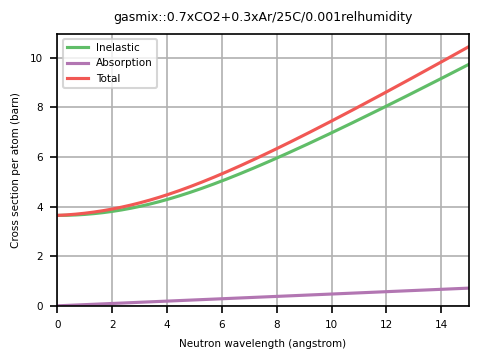

In [54]:
ncplot.plot_xsect("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity")

One thing you might have noticed about the dumped NCMAT data above is the section:
```
@TEMPERATURE
  298.15
```
It means that NCrystal will refuse to let the user change the temperature of this material further, which is a safeguard against someone trying to change the temperature like this (which would give a material with the wrong density!):

In [55]:
try:
    NC.load("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity;temp=10K")
except NC.NCBadInput as e:
    print("NCBadInput ERROR: %s"%e)

NCBadInput ERROR: 0.7xCO2+0.3xAr/0.001relhumidity/25C requested temperature (10K) is incompatible with temperature (298.15K) at which input data is valid.


The right way to modify the temperature is inside the "filename" part (changing `25C`->`10K`):

In [56]:
NC.load("gasmix::0.7xCO2+0.3xAr/10K/0.001relhumidity")


LoadedMaterial(Info=<NCrystal.core.Info object at 0x70e1393e3f50>, Scatter=<NCrystal.core.Scatter object at 0x70e1394d4890>, Absorption=<NCrystal.core.Absorption object at 0x70e1393e3110>)

Two other "quick factories" exists, which can be useful in the case where a non-gaseous material needs to be included in a simulation, but where the exact material *structure* is not important (or, not known!):

* `"freegas::Ar/2.5e-5perAa3"`
* `"freegas::CF4/3.72kgm3"`
* `"freegas::CO2/1.98kgm3"`
* `"freegas::He/0.17kgm3/He_is_He3"`
* `"solid::Al2O3/4gcm3"`
* `"solid::B4C/2.52gcm3/B_is_0.95_B10_0.05_B11"`
* `"solid::CH2/1gcm3"`
* `"solid::Gd2O3/7.07gcm3"`
* `"solid::Al2O3/4gcm3/TDebye750K_Al/TDebye1000K_O"`
* `"solid::Al2O3/4gcm3/TDebye900K"`


These materials will get the density and composition which can be inferred from the strings. In the case of `freegas::` materials, all atoms will be modelled as independent free gas atoms. In a way this is no different to how materials are mostly modelled in OpenMC/Geant/MCNP/..., but it is useful to have such simple materials in NCrystal as well - not the least for when NCrystal is used standalone or in applications like McStas where there is otherwise no universal concept of a "base material".

The `solid::` materials are very similar, but they differ in that their simplistic dynamics will be appropriate for bound atoms rather than free atoms. Such a feature was easy enough to add in NCrystal, since we can generate all dynamics of an amorphous material based on a 1D phonon DOS curve, and we simply use a simplistic phonon DOS curve as input (the Debye model).

## Multiphase materials


Multiphase materials can be composed in cfg-strings from existing materials the following `"phases<...>"` cfg-string syntax, listing the desired phases and their **volume** (not mass) fraction. This is as easy as:
```
   "phases<0.1*PbS_sg225_LeadSulfide.ncmat&0.9*Epoxy_Araldite506_C18H20O3.ncmat>"
```
Cfg-parameters can be applied as always, affecting either a single phase or all phases depending on placement. For instance, in the following (somewhat silly) material the temperature of 300K applies to all phases, while the d-spacing cutoff only affects the aluminium:
```
   "phases<0.25*Al_sg225.ncmat;dcutoff=0.4&0.75*Be_sg194.ncmat>;temp=300K"
```
Note that whitespace is allowed, if you feel it provides a more readable string Also note that the `"phases<>"` syntax has been chosen specifically to support the use-case that one can always override parameters in cfg-strings by appending a simple string to them. For instance appending the string `";temp=400K"` to any cfg-string will override the temperature value - whether or not the cfg-string uses the `"phases<...>"` syntax or not.

For convenience it is also possible to define multiple phases directly inside NCMAT data. Additionally, NCrystal also has framework-level support for SANS physics, which can be thought of as diffraction due to the geometric layouts of the individual phases. We shall see an example in another notebook.

## Atom data
NCrystal obviously contains an internal database of scattering lengths, cross sections and masses, of a large number of natural elements and specific isotopes. You can access this database directly if needed:

In [57]:
NC.atomDB('Al')

Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815amu Z=13)

In [58]:
NC.atomDB('He3')

He3(cohSL=5.74fm cohXS=4.14032barn incXS=1.6barn absXS=5333barn mass=3.01603amu Z=2 A=3)

You can access the data programatically, and as always you can find inline help:

In [59]:
data_H = NC.atomDB('H')
data_D = NC.atomDB('D')
print(data_H.coherentScatLen())
print(data_D.coherentScatLen())
help(data_H)

-0.3739
0.6671
Help on AtomData in module NCrystal.core object:

class AtomData(RCBase)
 |  AtomData(rawobj)
 |
 |  Class providing physical constants related to a particular mix of
 |  isotopes. This can be used to represent elements (i.e. all isotopes having
 |  same Z) in either natural or enriched form, but can also be used to
 |  represent atoms in doped crystals. E.g. if a small fraction (0.1%) of
 |  Cr-ions replace some Al-ions in a Al2O3 lattice, the AtomData could
 |  represent a mix of 0.1% Cr and 99.9% Al.
 |
 |  Method resolution order:
 |      AtomData
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  A(self)
 |      Number of nucleons per nuclei (0 if not well defined or natural element).
 |
 |  Z(self)
 |      Number of protons per nuclei (0 if not well defined).
 |
 |  __init__(self, rawobj)
 |      internal usage only
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  averageMassAMU(self)
 | 

In [60]:
for e in NC.iterateAtomDB():
    print(e)

H(cohSL=-3.739fm cohXS=1.75679barn incXS=80.26barn absXS=0.3326barn mass=1.00798amu Z=1)
H1(cohSL=-3.7406fm cohXS=1.7583barn incXS=80.27barn absXS=0.3326barn mass=1.00783amu Z=1 A=1)
H2(cohSL=6.671fm cohXS=5.59232barn incXS=2.05barn absXS=0.000519barn mass=2.0141amu Z=1 A=2)
H3(cohSL=4.792fm cohXS=2.88565barn incXS=0.14barn absXS=0barn mass=3.01605amu Z=1 A=3)
He(cohSL=3.26548fm cohXS=1.34barn incXS=0barn absXS=0.00747barn mass=4.0026amu Z=2)
He3(cohSL=5.74fm cohXS=4.14032barn incXS=1.6barn absXS=5333barn mass=3.01603amu Z=2 A=3)
He4(cohSL=3.26fm cohXS=1.3355barn incXS=0barn absXS=0barn mass=4.0026amu Z=2 A=4)
Li(cohSL=-1.9fm cohXS=0.453646barn incXS=0.92barn absXS=70.5barn mass=6.94094amu Z=3)
Li6(cohSL=2fm cohXS=0.502655barn incXS=0.46barn absXS=940barn mass=6.01512amu Z=3 A=6)
Li7(cohSL=-2.22fm cohXS=0.619321barn incXS=0.78barn absXS=0.0454barn mass=7.016amu Z=3 A=7)
Be(cohSL=7.79fm cohXS=7.62579barn incXS=0.0018barn absXS=0.0076barn mass=9.01218amu Z=4)
Be9(cohSL=7.79fm cohXS=7.625

It is always possible to override some of these values for a particular material, or even to provide values for elements or isotopes that might be missing. This can be done either in the `@ATOMDB` section of NCMAT data (cf. https://github.com/mctools/ncrystal/wiki/NCMAT-format), or through the `atomdb` cfg-string variable (cf. https://github.com/mctools/ncrystal/wiki/CfgRefDoc). We will return to this subject when discussing the `NCMATComposer` in another Notebook.

## References and where to find more information

The available documentation for NCrystal is a work in progress, and while we still didn't consolidate this in one glorious location, there is plenty of information to be found:

* The official wiki: https://github.com/mctools/ncrystal/wiki/
  * This includes the [Data-library](https://github.com/mctools/ncrystal/wiki/Data-library) and [CfgRefDoc](https://github.com/mctools/ncrystal/wiki/CfgRecDoc) pages which most users might need.
  * For advanced users, the offical [NCMAT format specification](https://github.com/mctools/ncrystal/wiki/NCMAT-format) is there as well, along with instructions for usage or development of optional [plugins](https://github.com/mctools/ncrystal/wiki/Plugins).
  * Be sure to check out the various release Announcement pages you find in the sidebar, since a lot of information was described there but still didn't make it anywhere else.
* The Python API contains doc-strings everywhere, accessible though the `help` function. Please use it!
* All command-line tools support a `--help` flag, which will result in usage instructions being printed out.
* For C++ developers: Lots and lots of thorough comments are left everywhere in the code.
* The [README](https://github.com/mctools/ncrystal/blob/master/README) and [INSTALL](https://github.com/mctools/ncrystal/blob/master/INSTALL) files from the NCrystal release itself.
* Publications (also, **please remember to cite if you use NCrystal and want to support us!**):
  * X.-X. Cai and T. Kittelmann, NCrystal: A library for thermal neutron transport, Computer Physics Communications 246 (2020) 106851, https://doi.org/10.1016/j.cpc.2019.07.015
  * T. Kittelmann and X.-X. Cai, Elastic neutron scattering models for NCrystal, Computer Physics Communications 267 (2021) 108082, https://doi.org/10.1016/j.cpc.2021.108082
  * X.-X. Cai, T. Kittelmann, et. al., "Rejection-based sampling of inelastic neutron scattering", Journal of Computational Physics 380 (2019) 400-407, https://doi.org/10.1016/j.jcp.2018.11.043

## How to get help

There are many options for how to get help with NCrystal. We welcome all contact, but given that we are normally stretched for manpower, some means of contact are certainly easier for us to deal with than others!

* **Using the discussion forum for questions or discussions**
  * Our discussions forum at https://github.com/mctools/ncrystal/discussions is where we hope that users of all levels will ask their questions!
  * Do not be afraid to ask "stupid questions". Such questions are rarely actually stupid, but often expose the need for better documentation, or real bugs in our code. Or perhaps all there is needed is another NCrystal user to share the solution they had in a similar situation.
  * Should a question end up exposing a bug (or feature request) for NCrystal, we can also easily convert them to proper GitHub "issues", and include other relevant experts in the discussions.
  * Feel free to use the forum for other NCrystal-related subjects as well.
  * *Please sign up to "watch" the discussions if you are an NCrystal user that want to contribute by helping other users*
* **Reporting bugs or feature requests**
  * Please do so using the tracker at https://github.com/mctools/ncrystal/issues
  * Don't worry if you don't get the meta-data of the request correct, we can fix it up later. Also don't worry if your issue is a valid one or not - we can always simply provide advice and then close the issue.
  * Do try to include as many details as possible about your issue, so we don't have to drag them out of you.
* **Sending emails to NCrystal developers**
  * Of course you can do so, but please consider first if you could not use one of the other manner of contacts above.
  * Emails can be very distracting, since in practice they must be dealt with either "immediately" or "never".
  * We will never be upset at getting emails, but you might get a short reply asking you to post your problem in one of the GitHub channels instead.
